In [1]:
from keras.models import Model
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D

import numpy as np
from matplotlib import pyplot as plt

import os
from PIL import Image
from skimage.util.shape import view_as_blocks
from math import sqrt

Using TensorFlow backend.


In [2]:
import imgpatch
from imp import reload
from sklearn.model_selection import train_test_split

In [3]:
# The image is actually 240 x 416, 
#     so we will have 15 x 26 patches with frame shape of 15 x 26 instead of 26 x 15
data1_path = 'RaceHorses_416x240_30'

# reload(imgpatch)
image_data = imgpatch.load_data(data1_path) 
# Normalize image_data
image_data = image_data / 255.0

In [4]:
patch_shape = (16, 16, 3)

patch_data = imgpatch.get_patch(image_data, patch_shape)

(117000, 16, 16, 3)


In [5]:
n_image = image_data.shape[0]
n_frame = patch_data.shape[0] // n_image

data = patch_data.reshape(list([n_image, n_frame]) + list(patch_data.shape[1:]))
print(data.shape)

train_data, test_data = train_test_split(data, train_size = 0.75)

train_data = train_data.reshape([train_data.shape[0]*n_frame] + list(data.shape[2:]))
print(train_data.shape)

test_data = test_data.reshape([test_data.shape[0]*n_frame] + list(data.shape[2:]))
print(test_data.shape)

(300, 390, 16, 16, 3)
(87750, 16, 16, 3)
(29250, 16, 16, 3)


In [6]:
input_img = Input(shape=patch_shape)

e = Conv2D(64, (7, 7), activation='relu', padding='same')(input_img)
e = MaxPooling2D((2, 2), padding='same')(e)
e = Conv2D(32, (5, 5), activation='relu', padding='same')(e)
#e = MaxPooling2D((2, 2), padding='same')(e)
e = Conv2D(16, (1, 1), activation='relu', padding='same')(e)
e = Conv2D(8, (3, 3), activation='relu', padding='same')(e)
encoded = Conv2D(4, (3, 3), activation='relu', padding='same')(e)

d = Conv2D(4, (3, 3), activation='relu', padding='same')(encoded)
d = Conv2D(8, (3, 3), activation='relu', padding='same')(d)
d = Conv2D(16, (1, 1), activation='relu', padding='same')(d)
#d = UpSampling2D((2, 2))(d)
d = Conv2D(32, (5, 5), activation='relu', padding='same')(d)
d = UpSampling2D((2, 2))(d)
d = Conv2D(64, (7, 7), activation='relu', padding='same')(d)
decoded = Conv2D(3, (1, 1), activation='linear')(d)

autoencoder = Model(input_img, decoded)
autoencoder.summary()
autoencoder.compile(optimizer='adam', loss='mse')

autoencoder.fit(train_data, train_data, epochs=10, batch_size=25)

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 16, 16, 3)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 64)        9472      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 32)          51232     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 8, 8, 16)          528       
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 8, 8, 8)           1160      
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 8, 8, 4)           292 

In [7]:
decoded_patches = autoencoder.predict(test_data)
decoded_patches.shape

(29250, 16, 16, 3)

In [12]:
test_img = decoded_patches[:n_frame]
print(test_img.shape)

# reload(imgpatch)
block_shape = imgpatch.get_block_shape(image_data.shape, patch_shape)
img = imgpatch.merge_block(test_img, block_shape)
img.shape

img = np.minimum(img, np.ones(img.shape, dtype = np.float32))
img = np.maximum(img, np.zeros(img.shape, dtype = np.float32))

(390, 16, 16, 3)


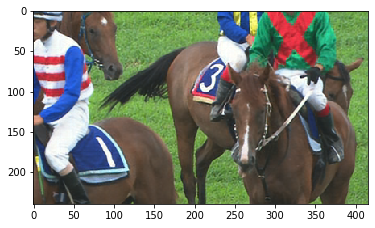

In [13]:
plt.imshow(img)